<center> <h1> Tabular Playground Series - Feb 2022  </h1> </center> 


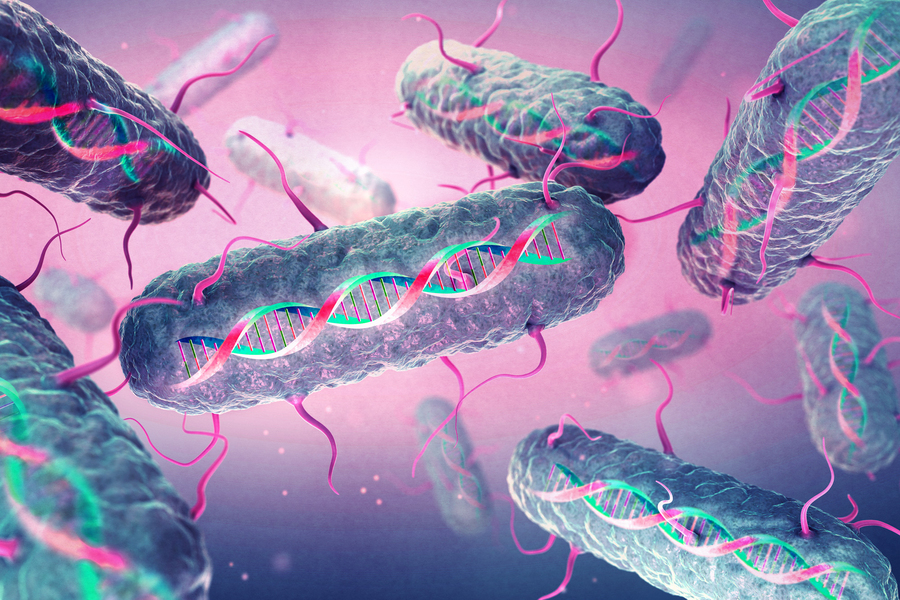


<h2 style='background:#f57369; border:0; color:white'><center>Overview</center></h2>


For the February 2022 Tabular Playground Series competition, our task is to classify 10 different bacteria species using data from a genomic analysis technique that has some data compression and data loss.
In this technique, 10-mer snippets of DNA are sampled and analyzed to give the histogram of base count. In other words, the DNA segment **ATATGGCCTT** becomes **A2T4G2C2**. 

<h2 style='background:#f57369; border:0; color:white'><center>About the data</center></h2>


Each row of data contains a spectrum of histograms generated by repeated measurements of a sample, each row containing the output of all 286 histogram possibilities , which then has a bias spectrum (of totally random ATGC) subtracted from the results.
The data (both train and test) also contains simulated measurement errors (of varying rates) for many of the samples, which makes the problem more challenging.

**Files**
- **train.csv** - the training set, which contains the spectrum of 10-mer histograms for each sample.
- **test.csv**- the test set; your task is to predict the bacteria species (target) for each row_id.
- **sample_submission.csv** -a sample submission file in the correct format

<h2 style='background:#f57369; border:0; color:white'><center>Notebook Set up </center></h2>
First let's set up the notebook by importing diffrent librarires ( pandas , numpy , matplotlib and others ).

In [ ]:
import os 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import plotly
import plotly.express as px
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split ,KFold,StratifiedKFold
from optuna.integration import lightgbm as lgb
import lightgbm as lgb
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder
from math import factorial
from sklearn.metrics import accuracy_score
from scipy.stats import mode
plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
import warnings
warnings.filterwarnings('ignore')
print("Packages Imported ")


#### Load  data files 

In [ ]:
%%time 
train = pd.read_csv("../input/tabular-playground-series-feb-2022/train.csv",index_col="row_id")
test = pd.read_csv("../input/tabular-playground-series-feb-2022/test.csv",index_col="row_id")
sample_submission= pd.read_csv("../input/tabular-playground-series-feb-2022/sample_submission.csv")

<h2 style='background:#f57369; border:0; color:white'><center>Explorotary Data analysis  </center></h2>
As in previous competions and diffrent project we will first start by taking a deep look into our data files and analysed before trying to model it.


#### Train Data 

In [ ]:
train.head(3)

##### General info about the train data 

In [ ]:
train.info()
train.shape

In [ ]:
train.isnull().sum()

The train data contains a 200000 raws and 288 columns.

##### Check and remove duplicates 

In [ ]:
train.drop_duplicates(keep='first', inplace=True) #drop dublicates 
train.duplicated().sum()
train.shape

#### Basic summary statistics

In [ ]:
train.describe().style.background_gradient(cmap='RdPu')

#### Feature variation

In [ ]:
# variables variaition   
df_var=train.var().reset_index()
df_var.columns =['feature', 'variation']
df_var.sort_values("variation",ascending = False)

### Target Variable
The target for this month competition is a multiclass variable , we have 10 classes which are ;

* Streptococcus_pyogenes,
* Salmonella_enterica,
* Enterococcus_hirar,
* Escherichia_coli 
* Campylobacter_jejuni
* Streptococcus_pneumoniae
* Staphylococcus_aureus'
* Escherichia_fergusonii'
* Bacteroides_fragilis'
* Klebsiella_pneumoniae



In [ ]:
plt.figure(figsize=(14, 7))
train.target.value_counts().plot.bar(color= "salmon")

As we can see the classes are equaly present with in the train data , which make it a balanced multi-class classification problem.

#### Test data 

In [ ]:
test.head(3)

#### General information about test data 

In [ ]:
test.info()
test.shape

In [ ]:
test.isnull().sum()

the test data comes with shape (100000, 287) where all variables are of type float expect the raw id wich is of type int.

##### Basic summary statistic 

In [ ]:
test.describe().style.background_gradient(axis=1)

### 

#### Distribution of Mean and Standard deviation by row 

In [ ]:
plt.figure(figsize=(15,8))
features = train.columns.values[0:286]
sns.distplot(train[features].mean(axis=1),color="green", label='train')
sns.distplot(test[features].mean(axis=1),color="darkblue", label='test')
plt.title("Distribution of mean values per row in the train and test data")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
sns.distplot(train[features].std(axis=1),color="#2F4F4F", label='train')
sns.distplot(test[features].std(axis=1),color="#FF6347", label='test')
plt.title("Distribution of std per row in the train and test data ")
plt.legend()
plt.show()

<h2 style='background:#f57369; border:0; color:white'><center> LGBM Baseline </center></h2>


We will quickly try to model our data using [LGBM](https://lightgbm.readthedocs.io/en/latest/). And **PSEUDO LABELING** which is a semi supervised technique used to deal with small training data  and boost you  model confidence about predicting test data, if you want to learn more about pseeudo labeling and why it works i recommand you checking thus amazing [NOTEBOOK](https://www.kaggle.com/cdeotte/pseudo-labeling-qda-0-969) by CHRIS DEOTTE. with  that let's start preparing our data for training and predicting.

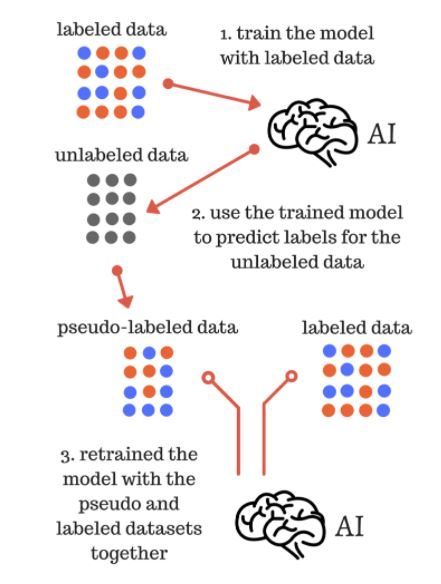

Image from [source](https://datawhatnow.com/pseudo-labeling-semi-supervised-learning/)

#### Data preparation 

In [ ]:
## read pseudolaes comes from https://www.kaggle.com/munumbutt/extratrees-stratifiedkfold-memory-optimization
pred_labels = pd.read_csv("../input/pseudolabels-data/submission.csv")
X_train = train.copy() 
test_df= test.copy()
test_df["target"]=pred_labels["target"].values
train_df = pd.concat([X_train, test_df], axis=0)

In [ ]:
y_target = train_df["target"].copy() ##target variable 
X_train= train_df.copy().drop("target", axis = 1)
X_test = test.copy()

In [ ]:
### label encoder for target 
label_encod = LabelEncoder()
y_encoded =label_encod.fit_transform(y_target)

In [ ]:
print(y_encoded.shape,y_target.shape,X_train.shape,X_test.shape )

#### Train  and Evaluation 
When tuning lgbm manually there are few [tips](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html) to consider: 

**For better Accuarcy** : 
* Use large max_bin
* Use small learning_rate with large num_iterations
* Use large num_leaves (may cause over-fitting)

**For dealing with overfitting**

* Decrease max_depth
* Decrease num_leaves
* Increase min_gain_to_split
* Increase min_data_in_leaf and min_sum_hessian_in_leaf
* Decrease num_iterations


In [ ]:
# random params for lgm 
lgbm_params =  { 'objective': 'multiclass',  
            'random_state': 48,
            'n_estimators':8000, 
            'device' : 'gpu',
            'learning_rate': 0.1,
            'max_depth': 120,
            'num_leaves': 40,
            'max_bin' : 180 ,
            'extra_trees' : True 
              }
#X_train= X_train.values
folds = 10 # use 10 folds 
preds = []
preds_prob =[]
val_score = []
feat_imp = pd.DataFrame()
KF = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42) 
for fold, (idx_train, idx_valid) in enumerate(KF.split(X_train, y_encoded)):
    X_tr, y_tr = X_train[idx_train], y_encoded[idx_train]
    X_val, y_val = X_train[idx_valid], y_encoded[idx_valid]
    # train lgbm baseline 
    baseline = lgb.LGBMClassifier(**lgbm_params)
    baseline.fit(X_tr, y_tr,eval_set=[(X_val,y_val)],early_stopping_rounds=15,verbose=0)
    # get validation score 
    val_preds = baseline.predict(X_val)
    accuracy = accuracy_score(y_val, val_preds)
    val_score.append(accuracy)    
    print(f"Fold={fold+1}, validatin Accuracy is : {accuracy:.6f}")
    ### get feature importance 
    fold_imp= pd.DataFrame()
    fold_imp["Feature"] = X_test.columns
    fold_imp["importance"] = baseline.feature_importances_
    fold_imp["fold"] = fold+ 1
    feat_imp = pd.concat([feat_imp, fold_imp], axis=0)
    ## get test predictions 
    pred = baseline.predict(X_test)
    preds.append(pred)
    preds_prob.append(baseline.predict_proba(X_test))

print("average validation Accuracy :", np.mean(val_score))

#### Feature importance 

Let's now check the feature importance of our baseline, for demonstration we only display the first 25 features that contributed most to classification.

In [ ]:
plot =feat_imp.groupby("Feature").mean().reset_index()
plt.figure(figsize=(18,10))
sns.barplot(x="importance", y="Feature", data=plot.sort_values(by="importance", ascending=False).iloc[:25,:],palette = 'YlGnBu_r')
plt.title('LightGBM Features importance (top20) ')
plt.tight_layout()
plt.show()

#### Graph visualization 
Let's now take a look at the tree graph of our baseline.

In [ ]:
lgb_graph = lgb.create_tree_digraph(baseline)
lgb_graph

#### Get predictions

In [ ]:
predictions =mode(preds).mode[0] #get mode of fold predictions
predictions = label_encod.inverse_transform(predictions) # inverse label encoder 

#### Submission 

In [ ]:
sample_submission['target'] =  predictions 
sample_submission.to_csv('lgbm_pseudolabeling.csv', index=False)
sample_submission.head(10)

#### Check test prediction against train labels

In [ ]:
plt.figure(figsize=(25,6))
ax1= sns.countplot(x=sample_submission.target, data=sample_submission,color='salmon')

#### Ways to improve the result 
In order to improve the result of this lgbm baseline you can try diffrent approches : 
* Data processing and engineering .
* Hyperparamaters tuning.
* Ensemble predictions with other gbdt models (catboost , xgb or even with DL models ).

  <h3 style='background:#f57369; border:0; color:white'><center>I hope you find this useful , Good Luck</center></h3>
